In [1]:
import torch
import torch.nn as nn
from functorch import make_functional, vmap, vjp, jvp, jacrev
import matplotlib.pyplot as plt
import numpy as np
device = 'mps'

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 32, (3, 3))
        self.conv3 = nn.Conv2d(32, 32, (3, 3))
        self.fc = nn.Linear(15488, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.relu()
        x = self.conv2(x)
        x = x.relu()
        x = self.conv3(x)
        x = x.flatten(1)
        x = self.fc(x)
        return x

In [2]:
x_train = torch.randn(20, 3, 32, 32, device=device)
x_test = torch.randn(5, 3, 32, 32, device=device)

In [3]:
import pandas as pd

data = pd.read_csv('~/data/MNIST/mnist_train.csv')

s1, s2 = 20,20
x_train = torch.tensor(data[:s1].drop('label', axis = 1).to_numpy(), device=device)/255
x_test_orig = torch.tensor(data[s1:s1+s2].drop('label', axis = 1).to_numpy(), device=device)/255

x_train = x_train.view(s1,1,28,28)
perm = np.random.permutation(784)

x_test = torch.Tensor(s2,784).to(device)

for i in range(len(x_test)):
    x_test[i] = x_test_orig[i,perm]

x_test = x_test.view(s2,1,28,28)
x_test_orig = x_test_orig.view(s2,1,28,28)

y = torch.tensor(data[:s1]['label'].to_numpy(), device=device)
y_test = torch.tensor(data[s1:s1+s2]['label'].to_numpy(), device=device)

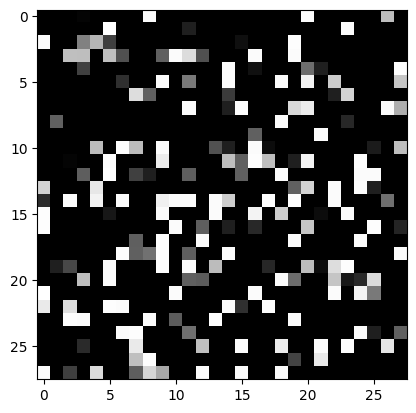

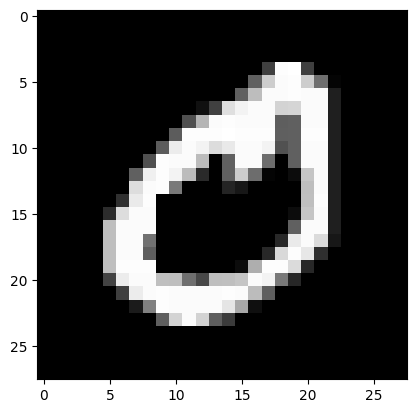

In [4]:
plt.imshow(x_test[1].view(28,28).cpu(), cmap='gray')
plt.show()
plt.imshow(x_test_orig[1].view(28,28).cpu(), cmap='gray')

In [5]:
net = CNN().to(device)
fnet, params = make_functional(net)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')


In [6]:
def fnet_single(params, x):
    return fnet(params, x.unsqueeze(0)).squeeze(0)

In [7]:
def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2):
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = [j.flatten(2) for j in jac1]
    
    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = [j.flatten(2) for j in jac2]
    
    # Compute J(x1) @ J(x2).T
    result = torch.stack([torch.einsum('Naf,Mbf->NMab', j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    result = torch.sum(result, dim=(2, 3))
    return result

In [8]:
def GramMatrix(net, x_train, x_test):
    fnet, params = make_functional(net)
    return empirical_ntk_jacobian_contraction(fnet_single, params, x_train, x_test)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migratin

(Vmax,Vmin)= 602.7298583984375 , 387.37225341796875
(Vmax_perm,Vmin_perm)= 451.4818115234375 , 369.3698425292969


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migratin

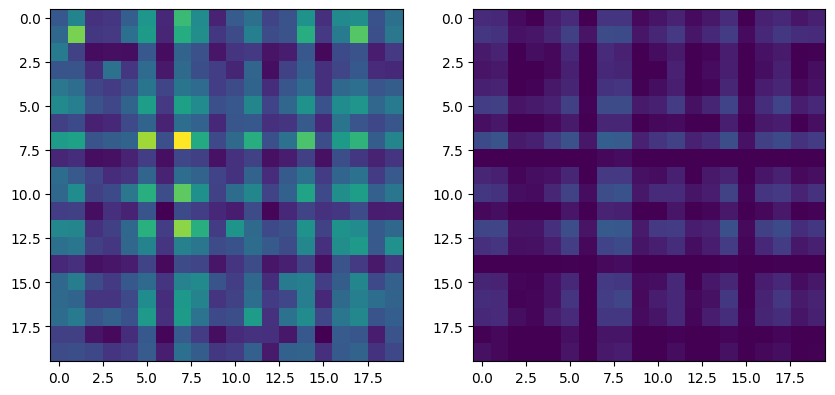

In [9]:
result = GramMatrix(net, x_train, x_test_orig)
result_perm = GramMatrix(net, x_train, x_test)

fig, axes = plt.subplots(1,2,figsize=(10,8) )

vmin, vmin_perm = result.min().item(), result_perm.min().item()
vmax, vmax_perm = result.max().item(), result_perm.max().item()

print('(Vmax,Vmin)=',vmax,',',vmin)
print('(Vmax_perm,Vmin_perm)=',vmax_perm,',',vmin_perm)

axes[0].imshow(result.view(s1,s2).cpu().detach(), vmin=vmin, vmax=vmax)
axes[1].imshow(result_perm.view(s1,s2).cpu().detach(), vmin=vmin, vmax=vmax)


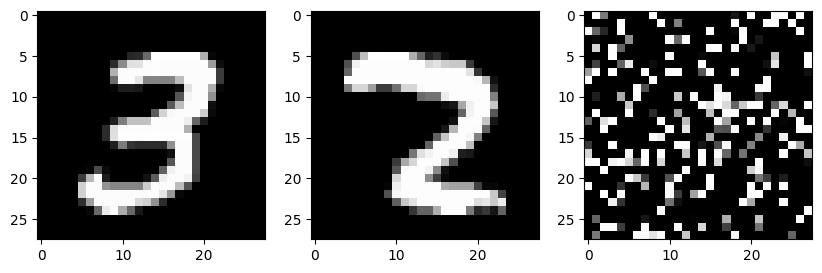

In [10]:
fig, axes = plt.subplots(1,3, figsize=(10,8) )
axes[0].imshow(x_train[7].view(28,28).cpu(), cmap='gray')
axes[1].imshow(x_test_orig[8].view(28,28).cpu(), cmap='gray')
axes[2].imshow(x_test[8].view(28,28).cpu(), cmap='gray')

In [11]:
gen = torch.Generator(device=device)
gen.manual_seed(123)

#y = torch.eye(10, device=device)[Y_temp]

In [12]:
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
MSE = nn.CrossEntropyLoss()

In [13]:
batch = 1
loss_eval = 99
wei_dist = []

for epoch in range(20):

        running_loss = 0.0
        for i in range(len(x_train)//batch):

            # Batch of training 
            ix = torch.randint(0, len(x_train), (batch,), generator=gen, device=device)

            # Training
            out = net(x_train[ix])
            loss = MSE(out, y[ix])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() 

            if i % loss_eval == loss_eval-1:
                print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {running_loss/loss_eval:.2f}')
                running_loss = 0.0
               

print('Finished Training')

Finished Training


In [14]:
torch.sum(torch.argmax(net(x_test), dim=1) == y_test)/len(x_test)

tensor(0.1500, device='mps:0')

In [15]:
res = GramMatrix(net, x_train, x_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration g

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/_functorch/deprecated.py:83: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration g

(Vmax,Vmin)= 3511.5986328125 , 792.0029907226562
(Vmax_perm,Vmin_perm)= 1763.80224609375 , 722.307861328125


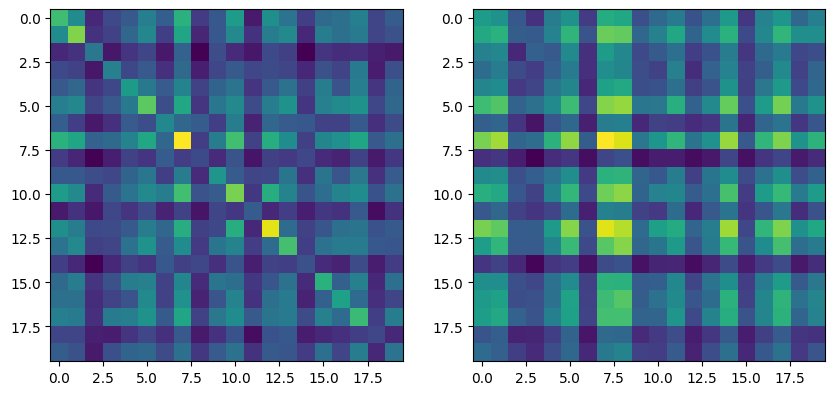

In [25]:
result = GramMatrix(net, x_train, x_train)
result_perm = GramMatrix(net, x_train, x_test)

fig, axes = plt.subplots(1,2,figsize=(10,8) )

vmin, vmin_perm = result.min().item(), result_perm.min().item()
vmax, vmax_perm = result.max().item(), result_perm.max().item()

print('(Vmax,Vmin)=',vmax,',',vmin)
print('(Vmax_perm,Vmin_perm)=',vmax_perm,',',vmin_perm)

axes[0].imshow(result.view(s1,s2).cpu().detach())
axes[1].imshow(result_perm.view(s1,s2).cpu().detach())

In [17]:
torch.equal(res, result)

False

In [26]:
L, V = torch.linalg.eig(result.cpu())

L_p, V_p = torch.linalg.eig(result_perm.cpu())

print(L)
print(L_p)

tensor([32361.9922+0.j,  2598.8542+0.j,  2285.0464+0.j,  1465.0090+0.j,  1403.2081+0.j,
         1105.7255+0.j,   923.1635+0.j,   842.7121+0.j,   616.5671+0.j,   589.7847+0.j,
          510.0450+0.j,    39.5935+0.j,   425.3823+0.j,   116.7751+0.j,   143.1880+0.j,
          304.8100+0.j,   185.4317+0.j,   212.5029+0.j,   264.5562+0.j,   238.5513+0.j],
       grad_fn=<LinalgEigBackward0>)
tensor([ 2.2141e+04+0.0000j,  2.8617e+02+0.0000j, -4.0904e+01+148.7659j,
        -4.0904e+01-148.7659j,  1.2549e+02+0.0000j, -6.3256e+01+45.6774j,
        -6.3256e+01-45.6774j, -6.6170e+01+0.0000j, -5.0284e+01+0.0000j,
         2.0729e+01+60.6065j,  2.0729e+01-60.6065j, -7.9112e+00+55.2178j,
        -7.9112e+00-55.2178j,  5.9274e+01+28.3994j,  5.9274e+01-28.3994j,
        -1.4427e+01+0.0000j, -3.0621e+00+0.0000j,  3.3081e+01+17.8725j,
         3.3081e+01-17.8725j,  3.4126e+01+0.0000j],
       grad_fn=<LinalgEigBackward0>)


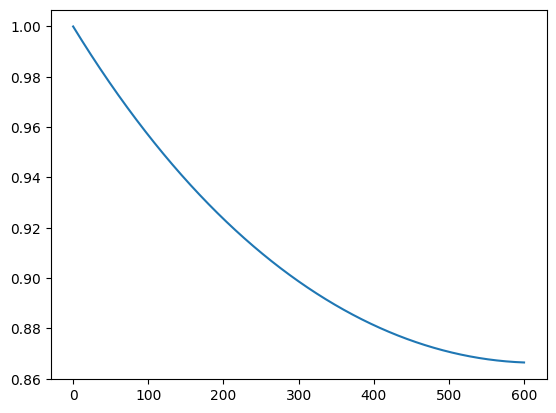

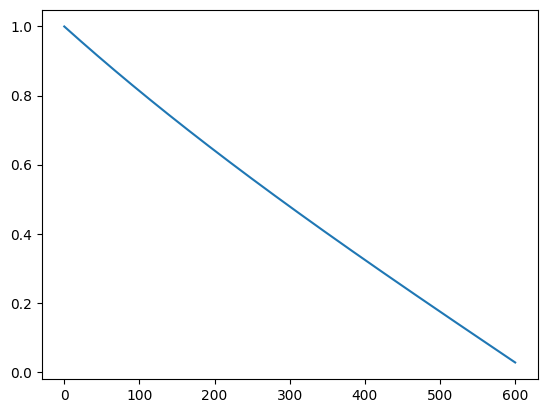

In [66]:
f = np.array([1])
lam = np.array([1])
eta = 2
m=4096

for i in range(600):

    lam = np.append(lam, lam[-1] + eta*f[-1]**2/m*(eta*lam[-1]/m - 4 ) )

    f = np.append(f, (1 - eta*lam[-1]/m + eta**2*f[-1]**2/m**2 )*f[-1] )

plt.plot(f)
plt.show()
plt.plot(lam)
plt.show()


In [6]:
print(lam)

[  1.          -2.99999961  -7.         -11.00000117 -15.00000312
 -19.00000586 -23.00000937 -27.00001367 -31.00001875 -35.00002461
 -39.00003125 -43.00003867 -47.00004687 -51.00005586 -55.00006562
 -59.00007617 -63.0000875  -67.00009961 -71.0001125  -75.00012617
 -79.00014062]


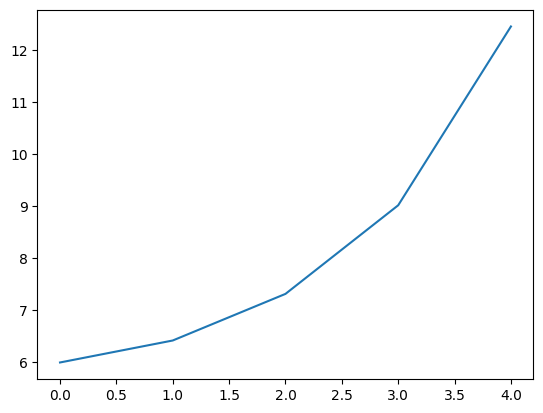

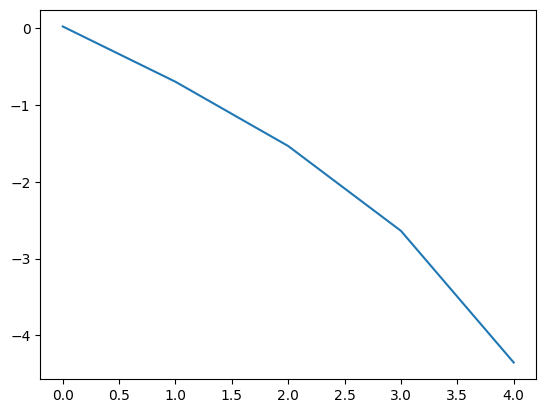

In [59]:
f = np.array([6])
lam = np.array([0.02])
eta = 0.08
m= 16

for i in range():

    lam = np.append(lam, lam[-1] + eta*f[-1]**2/m*(eta*lam[-1] - 4 ) )
    f = np.append(f, (1-eta*lam[-1] + eta**2*f[-1]**2/m )*f[-1] )

plt.plot(f)
plt.show()
plt.plot(lam)
plt.show()